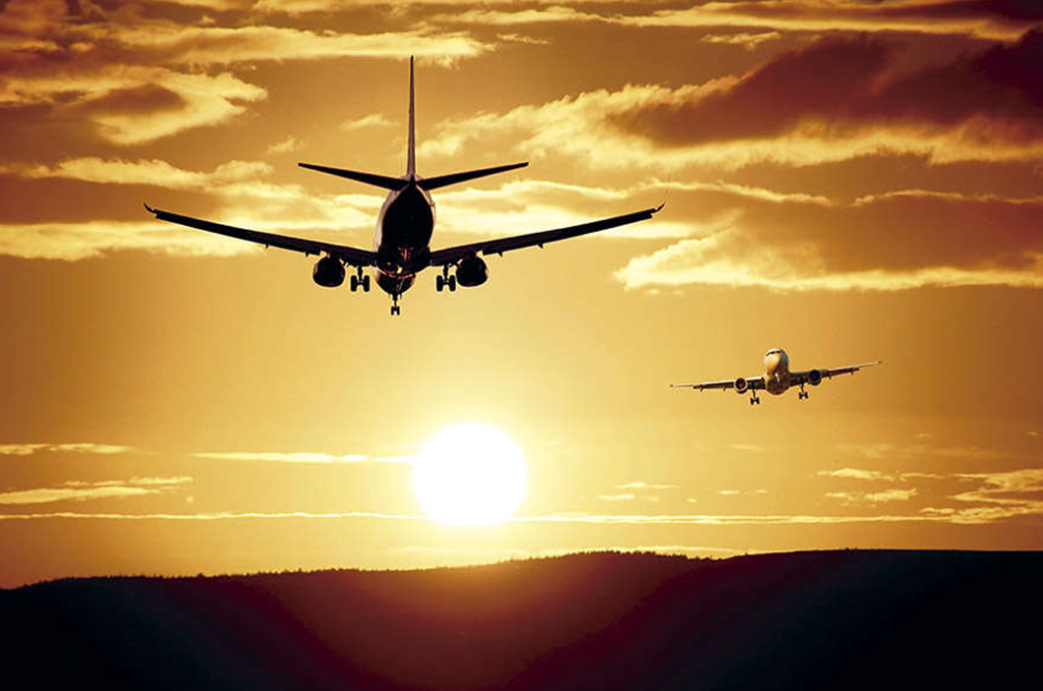

# **Predicción del retraso de las salidas y llegadas de las líneas aéreas**

In [1]:
# Libraries to help with reading and manipulating data
import numpy as np
import time
import re
from math import radians, sin, cos, sqrt, atan2

# Plot autocorrelation
import pandas as pd
from pandas.plotting import autocorrelation_plot

# Libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# os related functionalities
import os
from pathlib import Path

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)

# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 100)


import sklearn
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

# To create the pipeline
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline, Pipeline

# Libraries different ensemble classifiers
from sklearn.ensemble import (RandomForestRegressor,
                              GradientBoostingRegressor, 
                              AdaBoostRegressor,
                              ExtraTreesRegressor,
                              BaggingRegressor)

# To tune different models and standardize
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

# Libraries to get different metric scores
from sklearn.metrics import (confusion_matrix,
                             accuracy_score,
                             precision_score,
                             recall_score,
                             f1_score,
                             mean_squared_error,
                             mean_absolute_error,
                             r2_score,
                             mean_absolute_percentage_error)

import xgboost
from xgboost import XGBRegressor

import werkzeug
import flask
import gunicorn
import streamlit
from importlib.metadata import version

# to copy files between directories
import shutil
import glob

# To serialize the model
import joblib

# API request
import requests

# for hugging face space authentication to upload files
from huggingface_hub import login, HfApi, create_repo

# obtener la distancia entre las coordenadas gps
from haversine import haversine

# to create correlation network graphs
import networkx as nx

# Manual autocorrelation calculation (without statsmodels)
from scipy import stats  # Usually comes with scipy

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from statsmodels.graphics.tsaplots import plot_pacf


import gradio as gr
import warnings
warnings.filterwarnings('ignore')

In [2]:
# setting start time for models
time_model_ini = time.time()
# Flight Delay Prediction System - Model Comparison & Selection

# ============================================================================
# 1. SETUP STARTS HERE
# ============================================================================

print("✅ Prediction System Setup Started")
print(f"⏰ {time.strftime('%Y-%m-%d %H:%M:%S')}")
df_path = "./dataset/"

✅ Prediction System Setup Started
⏰ 2025-12-26 21:06:40


In [3]:
# ============================================================================
# 2. PREPARING DATA
# ============================================================================

print("✅ Loading cleaned dataset...")
vuelos = df_path+"df_cleaned_reduced.csv"
data_cleaned = pd.read_csv(vuelos)
print(f"✅ Cleaned dataset loaded from {vuelos}")

print(f"\n📊 Dataset loaded: {data_cleaned.shape[0]:,} rows, {data_cleaned.shape[1]} columns")
print("\nFirst few rows:")
display(data_cleaned.head())

print("\n📋 Dataset Info:")
print(f"   Memory usage: {data_cleaned.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"   Missing values: {data_cleaned.isnull().sum().sum()}")
print(f"   Duplicates: {data_cleaned.duplicated().sum()}")

✅ Loading cleaned dataset...
✅ Cleaned dataset loaded from ./dataset/df_cleaned_reduced.csv

📊 Dataset loaded: 136,777 rows, 54 columns

First few rows:


,flight_date,day_of_week_num,airline_name,aircraft_tail_num,dep_airport_code,dep_city_name,dep_time_label,dep_delay_min,dep_delay_tag,dep_delay_type,arr_airport_code,arr_city_name,arr_delay_min,arr_delay_type,flight_duration_min,flight_distance_type,delay_carrier_min,delay_weather_min,delay_nas_min,delay_security_min,delay_last_aircraft_min,aircraft_manufacturer,aircraft_model,aircraft_age_years,dep_airport_name,dep_city,dep_state,dep_country,dep_latitude,dep_longitude,arr_airport_name,arr_city,arr_state,arr_country,arr_latitude,arr_longitude,dep_temp_avg,dep_temp_min,dep_temp_max,dep_precip,dep_snow,dep_wind_dir,dep_wind_speed,dep_pressure,arr_temp_avg,arr_temp_min,arr_temp_max,arr_precip,arr_snow,arr_wind_dir,arr_wind_speed,arr_pressure,day_of_week_name,route_distance_km
0,2023-04-15,6,Alaska Airlines Inc.,N523AS,ADK,"Adak Island, AK",Afternoon,-17,0,Low <5min,ANC,"Anchorage, AK",-12,Low <5min,165,Short Haul >1500Mi,0,0,0,0,0,BOEING,737 NG,15,Adak Airport,Adak,AK,USA,51.87796,-176.64603,Ted Stevens Anchorage International Airport,Anchorage,AK,USA,61.17432,-149.99619,4.2,3.3,6.1,0.0,0.0,255.0,21.6,1026.8,1.7,-0.5,7.8,0.0,660.0,13.0,4.7,1000.2,Saturday,1913.266717
1,2023-11-08,3,Alaska Airlines Inc.,N526AS,ADK,"Adak Island, AK",Afternoon,23,1,Medium >15min,ANC,"Anchorage, AK",35,Medium >15min,168,Short Haul >1500Mi,0,0,12,23,0,BOEING,737 NG,15,Adak Airport,Adak,AK,USA,51.87796,-176.64603,Ted Stevens Anchorage International Airport,Anchorage,AK,USA,61.17432,-149.99619,5.1,0.6,8.9,2.8,0.0,214.0,28.4,997.6,-1.4,-2.8,1.1,20.3,178.0,3.0,9.4,982.4,Wednesday,1913.266717
2,2023-03-10,5,Alaska Airlines Inc.,N941AK,ABQ,"Albuquerque, NM",Evening,-1,0,Low <5min,PDX,"Portland, OR",7,Low <5min,183,Short Haul >1500Mi,0,0,0,0,0,BOEING,737 NG,2,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919,Portland International Airport,Portland,OR,USA,45.58872,-122.59750,9.9,1.1,20.6,0.0,0.0,306.0,13.7,1013.8,6.0,2.8,10.0,3.6,0.0,212.0,13.7,1002.2,Friday,1786.611750
3,2023-02-27,1,Alaska Airlines Inc.,N277AK,ABQ,"Albuquerque, NM",Evening,-11,0,Low <5min,PDX,"Portland, OR",1,Low <5min,187,Short Haul >1500Mi,0,0,0,0,0,BOEING,737 NG,7,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919,Portland International Airport,Portland,OR,USA,45.58872,-122.59750,0.5,-6.0,12.8,0.0,0.0,161.0,9.0,1016.4,3.3,1.7,5.6,4.6,30.0,122.0,20.2,999.8,Monday,1786.611750
4,2023-01-14,6,Alaska Airlines Inc.,N566AS,ABQ,"Albuquerque, NM",Evening,-11,0,Low <5min,PDX,"Portland, OR",-33,Low <5min,163,Short Haul >1500Mi,0,0,0,0,0,BOEING,737 NG,17,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919,Portland International Airport,Portland,OR,USA,45.58872,-122.59750,4.2,-2.7,11.7,0.0,0.0,305.0,6.8,1017.1,8.6,6.7,11.1,6.4,0.0,109.0,14.0,995.9,Saturday,1786.611750



📋 Dataset Info:
   Memory usage: 204.57 MB
   Missing values: 0
   Duplicates: 0


In [4]:
# ============================================================================
# 2.1 information about the dataset
# ============================================================================
data_cleaned.describe().T

,count,mean,std,min,25%,50%,75%,max
day_of_week_num,136777.0,4.030181,2.011736,1.000000,2.000000,4.000000,6.000000,7.000000
dep_delay_min,136777.0,16.671165,73.518313,-44.000000,-6.000000,-2.000000,11.000000,2935.000000
dep_delay_tag,136777.0,0.386644,0.486983,0.000000,0.000000,0.000000,1.000000,1.000000
arr_delay_min,136777.0,11.453914,75.272493,-119.000000,-15.000000,-5.000000,12.000000,2916.000000
flight_duration_min,136777.0,148.945641,72.469105,17.000000,97.000000,135.000000,181.000000,734.000000
delay_carrier_min,136777.0,7.074603,48.079663,0.000000,0.000000,0.000000,0.000000,2916.000000
delay_weather_min,136777.0,1.011193,20.042559,0.000000,0.000000,0.000000,0.000000,1653.000000
delay_nas_min,136777.0,3.094680,18.269389,0.000000,0.000000,0.000000,0.000000,1487.000000
delay_security_min,136777.0,0.029493,1.194833,0.000000,0.000000,0.000000,0.000000,224.000000
delay_last_aircraft_min,136777.0,7.807299,42.082331,0.000000,0.000000,0.000000,0.000000,2027.000000


In [5]:
# ============================================================================
# 2.2 information about the dataset
# ============================================================================
data_cleaned.shape

(136777, 54)

In [6]:
cols_to_keep = ['airline_name',
                'dep_airport_name',
                'arr_airport_name',
                'day_of_week_name',
                'aircraft_manufacturer',
                'aircraft_model',
                'aircraft_tail_num',
                'flight_date',
                'delay_carrier_min',
                'delay_weather_min',
                'delay_nas_min',
                'delay_security_min',
                'delay_last_aircraft_min',
                'dep_delay_min',
                'arr_delay_min',
                'flight_duration_min',
                'route_distance_km',
                'dep_airport_code',
                'arr_airport_code',
                'dep_city_name',
                'arr_city_name']

data_cleaned = data_cleaned[cols_to_keep].copy()

In [7]:
# ============================================================================
# 2.5 information about the dataset
# ============================================================================
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136777 entries, 0 to 136776
Data columns (total 21 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   airline_name             136777 non-null  object 
 1   dep_airport_name         136777 non-null  object 
 2   arr_airport_name         136777 non-null  object 
 3   day_of_week_name         136777 non-null  object 
 4   aircraft_manufacturer    136777 non-null  object 
 5   aircraft_model           136777 non-null  object 
 6   aircraft_tail_num        136777 non-null  object 
 7   flight_date              136777 non-null  object 
 8   delay_carrier_min        136777 non-null  int64  
 9   delay_weather_min        136777 non-null  int64  
 10  delay_nas_min            136777 non-null  int64  
 11  delay_security_min       136777 non-null  int64  
 12  delay_last_aircraft_min  136777 non-null  int64  
 13  dep_delay_min            136777 non-null  int64  
 14  arr_

In [8]:
# ============================================================================
# 3. CHECK IF MODELS ALREADY EXIST
# ============================================================================

model_path = "./model_files_reduced/"
models_exist = all([os.path.exists(model_path+'best_model_dep_delay.pkl'),
                    os.path.exists(model_path+'best_model_arr_delay.pkl'),
                    os.path.exists(model_path+'label_encoders.pkl'),
                    os.path.exists(model_path+'features_dep.pkl'),
                    os.path.exists(model_path+'features_arr.pkl'),
                    os.path.exists(model_path+'model_metadata.pkl')])

RETRAIN_MODELS = not models_exist  # Set to False to skip training

print("="*60)
print("🔍 CHECKING FOR EXISTING MODELS")
print("="*60)

if models_exist:
    print("✅ Pre-trained models found!")
    print(f"   📂 Location: {model_path}")
    print("\n📦 Loading existing models...")
    
    # Load pre-trained models and artifacts
    best_model_dep = joblib.load(model_path+'best_model_dep_delay.pkl')
    best_model_arr = joblib.load(model_path+'best_model_arr_delay.pkl')
    label_encoders = joblib.load(model_path+'label_encoders.pkl')
    features_dep_encoded = joblib.load(model_path+'features_dep.pkl')
    features_arr_encoded = joblib.load(model_path+'features_arr.pkl')
    metadata = joblib.load(model_path+'model_metadata.pkl')
    
    # Extract metadata
    best_dep_model_name = metadata['dep_delay']['model_name']
    best_dep_mae = metadata['dep_delay']['mae']
    best_dep_r2 = metadata['dep_delay']['r2']
    
    best_arr_model_name = metadata['arr_delay']['model_name']
    best_arr_mae = metadata['arr_delay']['mae']
    best_arr_r2 = metadata['arr_delay']['r2']
    
    print(f"\n✅ Models loaded successfully!")
    print(f"  🛫 Departure Model: {best_dep_model_name} | MAE: {best_dep_mae:.2f} min | R²: {best_dep_r2:.4f}")
    print(f"  🛬 Arrival Model: {best_arr_model_name} | MAE: {best_arr_mae:.2f} min | R²: {best_arr_r2:.4f}")
    
    # Load comparison results if they exist
    if os.path.exists(model_path+'model_comparison_dep_delay.csv'):
        df_results_dep = pd.read_csv(model_path+'model_comparison_dep_delay.csv')
        df_results_arr = pd.read_csv(model_path+'model_comparison_arr_delay.csv')
        print(f"\n✅ Model comparison results loaded")
    
    print("\n⏭️ Pre-trained models loaded, skipping training.")
    
else:
    print("❌ No pre-trained models found")
    print("🔄 Will train new models from scratch")
    RETRAIN_MODELS = True

🔍 CHECKING FOR EXISTING MODELS
✅ Pre-trained models found!
   📂 Location: ./model_files_reduced/

📦 Loading existing models...

✅ Models loaded successfully!
  🛫 Departure Model: Gradient Boosting | MAE: 5.86 min | R²: 0.9846
  🛬 Arrival Model: Gradient Boosting | MAE: 5.99 min | R²: 0.9875

✅ Model comparison results loaded

⏭️ Pre-trained models loaded, skipping training.


In [9]:
# ============================================================================
# 4. FEATURE ENGINEERING (Always needed for new predictions)
# ============================================================================

print("\n" + "="*60)
print("🔧 FEATURE ENGINEERING")
print("="*60)

# Create lag features
data_cleaned = data_cleaned.sort_values(['airline_name', 'aircraft_tail_num', 'flight_date'])
data_cleaned['dep_delay_lag'] = data_cleaned.groupby(['airline_name', 'aircraft_tail_num'])['dep_delay_min'].shift(1)
data_cleaned['arr_delay_lag'] = data_cleaned.groupby(['airline_name', 'aircraft_tail_num'])['arr_delay_min'].shift(1)

# Fill NaN values
data_cleaned['dep_delay_lag'].fillna(0, inplace=True)
data_cleaned['arr_delay_lag'].fillna(0, inplace=True)

# Create additional features
data_cleaned['is_weekend'] = data_cleaned['day_of_week_name'].isin(['Saturday', 'Sunday']).astype(int)
data_cleaned['total_delay_history'] = data_cleaned['delay_carrier_min'] + \
                                      data_cleaned['delay_weather_min'] + \
                                      data_cleaned['delay_nas_min'] + \
                                      data_cleaned['delay_security_min'] + \
                                      data_cleaned['delay_last_aircraft_min']

print("✅ Created lag features")
print("✅ Created weekend indicator")
print("✅ Created total delay history")


🔧 FEATURE ENGINEERING
✅ Created lag features
✅ Created weekend indicator
✅ Created total delay history


In [10]:

# ============================================================================
# 6. PREPARE GRADIO INTERFACE DATA (Always needed)
# ============================================================================

print("\n" + "="*60)
print("🛠️ PREPARING GRADIO INTERFACE")
print("="*60)

# Get unique values for dropdown menus
airlines = sorted(data_cleaned['airline_name'].unique().tolist())
default_airline = airlines[0] if airlines else None # Select a default airline for initial load
dep_airports = sorted(data_cleaned['dep_airport_name'].unique().tolist())
arr_airports = sorted(data_cleaned['arr_airport_name'].unique().tolist())
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
aircraft_models = sorted(data_cleaned['aircraft_model'].unique().tolist())
manufacturers = sorted(data_cleaned['aircraft_manufacturer'].unique().tolist())

# Calculate average values
avg_carrier_delay = data_cleaned['delay_carrier_min'].mean()
avg_last_aircraft_delay = data_cleaned['delay_last_aircraft_min'].mean()
avg_weather_delay = data_cleaned['delay_weather_min'].mean()
avg_nas_delay = data_cleaned['delay_nas_min'].mean()
avg_security_delay = data_cleaned['delay_security_min'].mean()
    
print(f"✅ Prepared interface data")
print(f"  ✓ Tot Airlines: {len(airlines)}")
print(f"  ✓ First airline on the list: {default_airline}")
print(f"  ✓ Tot Airports: {len(dep_airports)}")
print(f"  ✓ Tot Aircraft models: {len(aircraft_models)}")



🛠️ PREPARING GRADIO INTERFACE
✅ Prepared interface data
  ✓ Tot Airlines: 15
  ✓ First airline on the list: Alaska Airlines Inc.
  ✓ Tot Airports: 349
  ✓ Tot Aircraft models: 21


In [11]:
# ============================================================================
# 7. CREATE RELATIONSHIP MAPPINGS FOR DYNAMIC FILTERS
# ============================================================================

print("\n" + "="*60)
print("Creating relationship mappings for dynamic filters...")
print("="*60)
print("✓✓✓ Relationship mappings initiated")

# Manufacturer -> Aircraft Models
print("✓ 1/6 Manufacturer -> Aircraft Models")
manufacturer_to_models = {}
for manuf in data_cleaned['aircraft_manufacturer'].unique():
    models_list = data_cleaned[data_cleaned['aircraft_manufacturer'] == manuf]['aircraft_model'].unique().tolist()
    manufacturer_to_models[manuf] = sorted(models_list)


# Airline -> Departure Airports
print("✓ 2/6 Airline -> Departure Airports")
airline_to_dep_airports = {}
for airline in data_cleaned['airline_name'].unique():
    airports = data_cleaned[data_cleaned['airline_name'] == airline]['dep_airport_name'].unique().tolist()
    airline_to_dep_airports[airline] = sorted(airports)

# Airline -> Arrival Airports
print("✓ 3/6 Airline -> Arrival Airports")
airline_to_arr_airports = {}
for airline in data_cleaned['airline_name'].unique():
    airports = data_cleaned[data_cleaned['airline_name'] == airline]['arr_airport_name'].unique().tolist()
    airline_to_arr_airports[airline] = sorted(airports)

# Airline -> Aircraft Manufacturers
print("✓ 4/6 Airline -> Aircraft Manufacturers")
airline_to_manufacturers = {}
for airline in data_cleaned['airline_name'].unique():
    manufs = data_cleaned[data_cleaned['airline_name'] == airline]['aircraft_manufacturer'].unique().tolist()
    airline_to_manufacturers[airline] = sorted(manufs)

# Airline -> Aircraft Models
print("✓ 5/6 Airline -> Aircraft Models")
airline_to_models = {}
for airline in data_cleaned['airline_name'].unique():
    models_list = data_cleaned[data_cleaned['airline_name'] == airline]['aircraft_model'].unique().tolist()
    airline_to_models[airline] = sorted(models_list)

# Dep Airport -> Arr Airports (routes)
print("✓ 6/6 Dep Airport -> Arr Airports (routes)")
dep_to_arr_airports = {}
for dep in data_cleaned['dep_airport_name'].unique():
    arr_airports_list = data_cleaned[data_cleaned['dep_airport_name'] == dep]['arr_airport_name'].unique().tolist()
    dep_to_arr_airports[dep] = sorted(arr_airports_list)

print("✓✓✓ Relationship mappings created")



Creating relationship mappings for dynamic filters...
✓✓✓ Relationship mappings initiated
✓ 1/6 Manufacturer -> Aircraft Models
✓ 2/6 Airline -> Departure Airports
✓ 3/6 Airline -> Arrival Airports
✓ 4/6 Airline -> Aircraft Manufacturers
✓ 5/6 Airline -> Aircraft Models
✓ 6/6 Dep Airport -> Arr Airports (routes)
✓✓✓ Relationship mappings created


In [12]:
# ============================================================================
# 8. GET INITIAL FILTERED VALUES FOR DROPDOWNS
# ============================================================================

print("\n" + "="*60)
print("🔧 GETTING INITIAL FILTERED VALUES")
print("="*60)

# Get initial values for the default airline
if default_airline:
    # Get departure airports for default airline
    initial_dep_airports = airline_to_dep_airports.get(default_airline, [])
    default_dep_airport = initial_dep_airports[0] if initial_dep_airports else None
    
    # Get manufacturers for default airline
    initial_manufacturers = airline_to_manufacturers.get(default_airline, [])
    default_manufacturer = initial_manufacturers[0] if initial_manufacturers else None
    
    # Get initial arrival airports (filtered by default airline and default departure airport)
    if default_dep_airport:
        airline_arr_airports = set(airline_to_arr_airports.get(default_airline, []))
        route_arr_airports = set(dep_to_arr_airports.get(default_dep_airport, []))
        initial_arr_airports = sorted(list(airline_arr_airports & route_arr_airports))
        default_arr_airport = initial_arr_airports[0] if initial_arr_airports else None
    else:
        initial_arr_airports = airline_to_arr_airports.get(default_airline, [])
        default_arr_airport = initial_arr_airports[0] if initial_arr_airports else None
    
    # Get initial aircraft models (filtered by default airline and default manufacturer)
    if default_manufacturer:
        airline_models_set = set(airline_to_models.get(default_airline, []))
        manuf_models_set = set(manufacturer_to_models.get(default_manufacturer, []))
        initial_aircraft_models = sorted(list(airline_models_set & manuf_models_set))
        default_aircraft_model = initial_aircraft_models[0] if initial_aircraft_models else None
    else:
        initial_aircraft_models = airline_to_models.get(default_airline, [])
        default_aircraft_model = initial_aircraft_models[0] if initial_aircraft_models else None
    
    print(f"✅ Initial values for {default_airline}:")
    print(f"   Departure airports: {len(initial_dep_airports)} options")
    print(f"   Arrival airports: {len(initial_arr_airports)} options")
    print(f"   Manufacturers: {len(initial_manufacturers)} options")
    print(f"   Aircraft models: {len(initial_aircraft_models)} options")
else:
    print("❌ No airlines found in dataset")


🔧 GETTING INITIAL FILTERED VALUES
✅ Initial values for Alaska Airlines Inc.:
   Departure airports: 89 options
   Arrival airports: 1 options
   Manufacturers: 2 options
   Aircraft models: 3 options


In [13]:
# ============================================================================
# 8. PREDICTION FUNCTION
# ============================================================================

def predict_delays(airline, dep_airport, arr_airport, day_of_week, aircraft_model, manufacturer, aircraft_age):
    """Predict delays using the loaded models"""
    try:
        
        # Get route-specific information
        route_data = data_cleaned[(data_cleaned['dep_airport_name'] == dep_airport) &
                                  (data_cleaned['arr_airport_name'] == arr_airport)]

        if len(route_data) > 0:
            flight_duration = route_data['flight_duration_min'].mean()
            route_distance = route_data['route_distance_km'].mean()
        else:
            flight_duration = data_cleaned['flight_duration_min'].mean()
            route_distance = data_cleaned['route_distance_km'].mean()

        
        # Encode inputs
        airline_enc = label_encoders['airline_name'].transform([airline])[0]
        dep_airport_enc = label_encoders['dep_airport_name'].transform([dep_airport])[0]
        arr_airport_enc = label_encoders['arr_airport_name'].transform([arr_airport])[0]
        day_enc = label_encoders['day_of_week_name'].transform([day_of_week])[0]
        model_enc = label_encoders['aircraft_model'].transform([aircraft_model])[0]
        manuf_enc = label_encoders['aircraft_manufacturer'].transform([manufacturer])[0]
        
        # Additional features
        is_weekend = 1 if day_of_week in ['Saturday', 'Sunday'] else 0
        total_delay_hist = avg_carrier_delay + avg_weather_delay + avg_nas_delay +avg_security_delay + avg_last_aircraft_delay
        
        # Build feature dictionary for departure delay
        feature_dict_dep = {'airline_name_encoded': airline_enc,
                            'dep_airport_name_encoded': dep_airport_enc,
                            'arr_airport_name_encoded': arr_airport_enc,
                            'day_of_week_name_encoded': day_enc,
                            'aircraft_model_encoded': model_enc,
                            'aircraft_manufacturer_encoded': manuf_enc,
                            'aircraft_age_years': aircraft_age,
                            'delay_carrier_min': avg_carrier_delay,
                            'delay_last_aircraft_min': avg_last_aircraft_delay,
                            'dep_delay_lag': 0,
                            'delay_weather_min': avg_weather_delay,
                            'delay_nas_min': avg_nas_delay,
                            'route_distance_km': route_distance,   # ✅ REQUIRED
                            'flight_duration_min': flight_duration,
                            'is_weekend': is_weekend,
                            'total_delay_history': total_delay_hist}
        
        X_dep = pd.DataFrame([feature_dict_dep])[features_dep_encoded]
        dep_delay_pred = best_model_dep.predict(X_dep)[0]
                
        # Create input array in correct order
        features_dep_input = [feature_dict_dep.get(f, 0) for f in features_dep_encoded]
        
        # Predict departure delay
        dep_delay_pred = best_model_dep.predict([features_dep_input])[0]
        
        # Build features for arrival delay
        feature_dict_arr = feature_dict_dep.copy()
        feature_dict_arr['dep_delay_min'] = dep_delay_pred
        feature_dict_arr['arr_delay_lag'] = 0

        X_arr = pd.DataFrame([feature_dict_arr])[features_arr_encoded]
        arr_delay_pred = best_model_arr.predict(X_arr)[0]
        
        # Create input array in correct order
        features_arr_input = [feature_dict_arr.get(f, 0) for f in features_arr_encoded]
        
        # Predict arrival delay
        arr_delay_pred = best_model_arr.predict([features_arr_input])[0]
        
        # Format output
        distance_text = f"{route_distance:.0f} km" if route_distance > 0 else "N/A"
    
    
        dep_code = data_cleaned.loc[data_cleaned['dep_airport_name'] == dep_airport, 'dep_airport_code'].iloc[0]
        arr_code = data_cleaned.loc[data_cleaned['arr_airport_name'] == arr_airport, 'arr_airport_code'].iloc[0]

    
        result = f"""
✈️ **FLIGHT DELAY PREDICTION**
{'='*50}

📍 **Flight Information**
   Route: {dep_airport} → {arr_airport}
   Airline: {airline}
   Aircraft: {manufacturer} {aircraft_model}
   Age: {aircraft_age} years
   Day: {day_of_week}
   Weekend: {"Yes" if is_weekend else "No"}
   Total Historical Delay: {total_delay_hist:.1f} minutes
   Route: {dep_airport} ({dep_code}) → {arr_airport} ({arr_code})
   Distance: {distance_text}
   Duration: {flight_duration:.0f} minutes

{'='*50}

🤖 **Model Information**
   Departure Model: {best_dep_model_name}
   Arrival Model: {best_arr_model_name}
   Dep Model MAE: {best_dep_mae:.2f} min
   Arr Model MAE: {best_arr_mae:.2f} min

{'='*50}

🔮 **PREDICTIONS**

   🛫 Departure Delay: {max(0, dep_delay_pred):.1f} minutes
   🛬 Arrival Delay: {max(0, arr_delay_pred):.1f} minutes
   
   Time Difference: {abs(arr_delay_pred - dep_delay_pred):.1f} minutes

{'='*50}

💡 **Interpretation**
"""
        
        # Departure interpretation
        if dep_delay_pred < 15:
            result += "\n   ✅ On-time departure expected"
            dep_status = "🟢"
        elif dep_delay_pred < 30:
            result += "\n   ⚠️ Minor departure delay expected"
            dep_status = "🟡"
        elif dep_delay_pred < 60:
            result += "\n   ⚠️ Moderate departure delay expected"
            dep_status = "🟠"
        else:
            result += "\n   ⛔ Significant departure delay expected"
            dep_status = "🔴"
        
        # Arrival interpretation
        if arr_delay_pred < 15:
            result += "\n   ✅ On-time arrival expected"
            arr_status = "🟢"
        elif arr_delay_pred < 30:
            result += "\n   ⚠️ Minor arrival delay expected"
            arr_status = "🟡"
        elif arr_delay_pred < 60:
            result += "\n   ⚠️ Moderate arrival delay expected"
            arr_status = "🟠"
        else:
            result += "\n   ⛔ Significant arrival delay expected"
            arr_status = "🔴"
        
        # Additional insights
        result += f"\n\n📊 **Status**: {dep_status} Departure | {arr_status} Arrival"
        
        if arr_delay_pred > dep_delay_pred + 10:
            result += "\n\n⚠️ Note: Delay expected to increase during flight"
        elif dep_delay_pred > arr_delay_pred + 10:
            result += "\n\n✈️ Note: Flight may recover some time in the air"
        
        return result
        
    except Exception as e:
        return f"❌ Error making prediction: {str(e)}\n\nPlease ensure all selections are valid."

In [14]:
# ============================================================================
# 9. FILTER FUNCTIONS FOR DYNAMIC DROPDOWNS
# ============================================================================

def filter_dep_airports(airline):
    """Filter departure airports based on selected airline"""
    if airline and airline in airline_to_dep_airports:
        choices = airline_to_dep_airports[airline]
        return gr.Dropdown(choices=choices, value=choices[0] if choices else None)
    return gr.Dropdown(choices=dep_airports, value=dep_airports[0])

def filter_arr_airports(airline, dep_airport):
    """Filter arrival airports based on airline and departure airport"""
    if airline and airline in airline_to_arr_airports:
        airline_arr_airports = set(airline_to_arr_airports[airline])
    else:
        airline_arr_airports = set(arr_airports)
    
    if dep_airport and dep_airport in dep_to_arr_airports:
        route_arr_airports = set(dep_to_arr_airports[dep_airport])
    else:
        route_arr_airports = set(arr_airports)
    
    filtered = sorted(list(airline_arr_airports & route_arr_airports))
    
    if filtered:
        return gr.Dropdown(choices=filtered, value=filtered[0])
    return gr.Dropdown(choices=arr_airports, value=arr_airports[0])

def filter_manufacturers(airline):
    """Filter manufacturers based on selected airline"""
    if airline and airline in airline_to_manufacturers:
        choices = airline_to_manufacturers[airline]
        return gr.Dropdown(choices=choices, value=choices[0] if choices else None)
    return gr.Dropdown(choices=manufacturers, value=manufacturers[0])

def filter_models(airline, manufacturer):
    """Filter aircraft models based on airline and manufacturer"""
    if airline and airline in airline_to_models:
        airline_models = set(airline_to_models[airline])
    else:
        airline_models = set(aircraft_models)
    
    if manufacturer and manufacturer in manufacturer_to_models:
        manuf_models = set(manufacturer_to_models[manufacturer])
    else:
        manuf_models = set(aircraft_models)
    
    filtered = sorted(list(airline_models & manuf_models))
    
    if filtered:
        return gr.Dropdown(choices=filtered, value=filtered[0])
    return gr.Dropdown(choices=aircraft_models, value=aircraft_models[0])

In [15]:
# ============================================================================
# 10. CREATE GRADIO UI
# ============================================================================

# ===========================================================================
# Displays the first UI - no predictions yet
# ============================================================================
with gr.Blocks(title="Flight Delay Prediction") as demo:
    gr.Markdown("# ✈️ Flight Delay Prediction System")
    gr.Markdown("### Intelligent filtering based on real airline operations data")
    
    # ==================================================
    # Prediction display area
    # 1st column top left
    # 2nd column top right
    # ===================================================
    with gr.Row():
        with gr.Column():
            general_info_display = gr.Markdown(f"""
                **📋 General Flight Information:**
                - ✈️ **Airline:** -- name
                - 🛫 **Departure Airport:** -- name (code)
                - 🛬 **Arrival Airport:** -- name (code)
                - 📅 **Day of Week:** -- day
                - 🏭 **Manufacturer:** -- name
                - 🛩️ **Aircraft Model:** -- name
                - 📆 **Aircraft Age:** -- years
                
                _Select flight details and click "Predict Delays" to see information_
            """)
        with gr.Column():
            prediction_disp_TR = gr.Markdown(f"""
                🔮 **Flight PREDICTION Details**
                
                _Predictions will appear here after clicking "Predict Delays"_
                
                - 🛫 **Departure Delay:** -- minutes
                - 🛬 **Arrival Delay:** -- minutes
                - ⏱️ **Time Difference:** -- minutes
                - ⏱️ **Trend:** -- minutes
                - ✈️ **Flight Duration:** -- minutes
                - 🚀 **Route:** --- → ---
                - 📏 **Route Distance:** -- km
            """)
            
    # ==================================================
    # User input area
    # dropdowns for user input
    # ==================================================
    with gr.Row():
        with gr.Column():
            gr.Markdown("#### Flight Details")
            
            # Use the filtered initial values
            airline = gr.Dropdown(choices=airlines, label="Airline", 
                                  value=default_airline, interactive=True)
            
            dep_airport = gr.Dropdown(choices=initial_dep_airports, 
                                      label="Departure Airport", 
                                      value=default_dep_airport, 
                                      interactive=True)
            
            arr_airport = gr.Dropdown(choices=initial_arr_airports, 
                                      label="Arrival Airport", 
                                      value=default_arr_airport, 
                                      interactive=True)
            
            day_of_week = gr.Dropdown(choices=days_of_week, 
                                      label="Day of Week", 
                                      value="Monday", interactive=True)
        
        with gr.Column():
            gr.Markdown("#### Aircraft Details")
            
            manufacturer = gr.Dropdown(choices=initial_manufacturers, 
                                       label="Manufacturer", 
                                       value=default_manufacturer, 
                                       interactive=True)
            
            aircraft_model = gr.Dropdown(choices=initial_aircraft_models, 
                                         label="Aircraft Model", 
                                         value=default_aircraft_model, 
                                         interactive=True)
            
            aircraft_age = gr.Slider(minimum=1, maximum=57, step=1, 
                                     label="Aircraft Age (years)", value=13)
    
    # Set up dynamic filtering (only on user interaction, not on programmatic changes)
    airline.input(fn=filter_dep_airports, inputs=[airline], outputs=[dep_airport])
    airline.input(fn=filter_manufacturers, inputs=[airline], outputs=[manufacturer])
    airline.input(fn=filter_arr_airports, inputs=[airline, dep_airport], outputs=[arr_airport])
    dep_airport.input(fn=filter_arr_airports, inputs=[airline, dep_airport], outputs=[arr_airport])
    manufacturer.input(fn=filter_models, inputs=[airline, manufacturer], outputs=[aircraft_model])
    airline.input(fn=filter_models, inputs=[airline, manufacturer], outputs=[aircraft_model])
    
    # Prediction button
    predict_btn = gr.Button("🔮 Predict Delays", variant="primary", size="lg")

    gr.Markdown("### 📋 Example Flights")
    label = gr.Markdown("➡️ Select an example to auto-fill the form with realistic flight data, and get the predicted delays.")
    
    # ============================================================================
    # Create a button-based example system
    # ============================================================================
    with gr.Row():
        example1_btn = gr.Button("🔵 Example 1: AA JFK → LAX", size="sm")
        example2_btn = gr.Button("🟢 Example 2: Delta ATL → LGA", size="sm")
        example3_btn = gr.Button("🟠 Example 3: United EWR → SFO", size="sm")
        example4_btn = gr.Button("🔴 Example 4: Endeavor CLT → DTW", size="sm")
    
    # Functions to load examples
    def load_example_1():
        # Return all values and also update dropdown choices to include these values
        airline_val = "American Airlines Inc."
        dep_val = "John F. Kennedy International Airport (New York International Airport)"
        arr_val = "Los Angeles International Airport"
        day_val = "Friday"
        model_val = "737"
        manuf_val = "BOEING"
        age_val = 10
        
        # Get filtered choices for this airline
        dep_choices = airline_to_dep_airports.get(airline_val, dep_airports)
        arr_choices = airline_to_arr_airports.get(airline_val, arr_airports)
        manuf_choices = airline_to_manufacturers.get(airline_val, manufacturers)
        
        # Get models for this airline and manufacturer
        airline_models_set = set(airline_to_models.get(airline_val, aircraft_models))
        manuf_models_set = set(manufacturer_to_models.get(manuf_val, aircraft_models))
        model_choices = sorted(list(airline_models_set & manuf_models_set))
        
        return (airline_val,
                gr.Dropdown(choices=dep_choices, value=dep_val),
                gr.Dropdown(choices=arr_choices, value=arr_val),
                day_val,
                gr.Dropdown(choices=model_choices if model_choices else aircraft_models, value=model_val),
                gr.Dropdown(choices=manuf_choices, value=manuf_val),
                age_val)
    
    def load_example_2():
        airline_val = "Delta Air Lines Inc"
        dep_val = "Hartsfield-Jackson Atlanta International Airport"
        arr_val = "LaGuardia Airport (Marine Air Terminal)"
        day_val = "Monday"
        model_val = "A320"
        manuf_val = "AIRBUS"
        age_val = 8
        
        dep_choices = airline_to_dep_airports.get(airline_val, dep_airports)
        arr_choices = airline_to_arr_airports.get(airline_val, arr_airports)
        manuf_choices = airline_to_manufacturers.get(airline_val, manufacturers)
        
        airline_models_set = set(airline_to_models.get(airline_val, aircraft_models))
        manuf_models_set = set(manufacturer_to_models.get(manuf_val, aircraft_models))
        model_choices = sorted(list(airline_models_set & manuf_models_set))
        
        return (airline_val,
                gr.Dropdown(choices=dep_choices, value=dep_val),
                gr.Dropdown(choices=arr_choices, value=arr_val),
                day_val,
                gr.Dropdown(choices=model_choices if model_choices else aircraft_models, value=model_val),
                gr.Dropdown(choices=manuf_choices, value=manuf_val),
                age_val)
    
    def load_example_3():
        airline_val = "United Air Lines Inc."
        dep_val = "Newark Liberty International Airport"
        arr_val = "San Francisco International Airport"
        day_val = "Wednesday"
        model_val = "777"
        manuf_val = "BOEING"
        age_val = 5
        
        dep_choices = airline_to_dep_airports.get(airline_val, dep_airports)
        arr_choices = airline_to_arr_airports.get(airline_val, arr_airports)
        manuf_choices = airline_to_manufacturers.get(airline_val, manufacturers)
        
        airline_models_set = set(airline_to_models.get(airline_val, aircraft_models))
        manuf_models_set = set(manufacturer_to_models.get(manuf_val, aircraft_models))
        model_choices = sorted(list(airline_models_set & manuf_models_set))
        
        return (airline_val,
                gr.Dropdown(choices=dep_choices, value=dep_val),
                gr.Dropdown(choices=arr_choices, value=arr_val),
                day_val,
                gr.Dropdown(choices=model_choices if model_choices else aircraft_models, value=model_val),
                gr.Dropdown(choices=manuf_choices, value=manuf_val),
                age_val)

    def load_example_4():
        airline_val = "Endeavor Air"
        dep_val = "Charlotte Douglas International Airport"
        arr_val = "Detroit Metropolitan Airport"
        day_val = "Tuesday"
        model_val = "CRJ"
        manuf_val = "CANADAIR REGIONAL JET"
        age_val = 7
        
        dep_choices = airline_to_dep_airports.get(airline_val, dep_airports)
        arr_choices = airline_to_arr_airports.get(airline_val, arr_airports)
        manuf_choices = airline_to_manufacturers.get(airline_val, manufacturers)
        
        airline_models_set = set(airline_to_models.get(airline_val, aircraft_models))
        manuf_models_set = set(manufacturer_to_models.get(manuf_val, aircraft_models))
        model_choices = sorted(list(airline_models_set & manuf_models_set))
        
        return (airline_val,
                gr.Dropdown(choices=dep_choices, value=dep_val),
                gr.Dropdown(choices=arr_choices, value=arr_val),
                day_val,
                gr.Dropdown(choices=model_choices if model_choices else aircraft_models, value=model_val),
                gr.Dropdown(choices=manuf_choices, value=manuf_val),
                age_val)

    
    # Connect example buttons
    example1_btn.click(fn=load_example_1, outputs=[airline, dep_airport, arr_airport, day_of_week, aircraft_model, manufacturer, aircraft_age])
    example2_btn.click(fn=load_example_2, outputs=[airline, dep_airport, arr_airport, day_of_week, aircraft_model, manufacturer, aircraft_age])
    example3_btn.click(fn=load_example_3, outputs=[airline, dep_airport, arr_airport, day_of_week, aircraft_model, manufacturer, aircraft_age])
    example4_btn.click(fn=load_example_4, outputs=[airline, dep_airport, arr_airport, day_of_week, aircraft_model, manufacturer, aircraft_age])

    # ===========================================================================
    # UPDATED PREDICTION FUNCTION - Returns 3 outputs now
    # ===========================================================================
    def predict_with_general_info(airline, dep_airport, arr_airport, day_of_week, aircraft_model, manufacturer, aircraft_age):
        # Get the full prediction result
        full_result = predict_delays(airline, dep_airport, arr_airport, day_of_week, aircraft_model, manufacturer, aircraft_age)
        
        # Get route distance
        route_data = data_cleaned[(data_cleaned['dep_airport_name'] == dep_airport) &
                                  (data_cleaned['arr_airport_name'] == arr_airport)]
        
        if len(route_data) > 0:
            route_distance = route_data['route_distance_km'].mean()
        else:
            route_distance = data_cleaned['route_distance_km'].mean()
        
        # Get city names for display
        dep_code = data_cleaned[data_cleaned['dep_airport_name'] == dep_airport]['dep_airport_code'].values[0]
        arr_code = data_cleaned[data_cleaned['arr_airport_name'] == arr_airport]['arr_airport_code'].values[0]
                
        # Get city names for display
        dep_city = data_cleaned[data_cleaned['dep_airport_name'] == dep_airport]['dep_city_name'].values[0]
        arr_city = data_cleaned[data_cleaned['arr_airport_name'] == arr_airport]['arr_city_name'].values[0]
                
        # Create the general flight info display
        general_info = f"""
**📋 General Flight Information:**
- ✈️ **Airline:** {airline}
- 🛫 **Departure Airport:** ({dep_code} - {dep_city}) {dep_airport}
- 🛬 **Arrival Airport:** ({arr_code} - {arr_city}) {arr_airport}
- 📅 **Day of Week:** {day_of_week}
- 🏭 **Manufacturer:** {manufacturer}
- 🛩️ **Aircraft Model:** {aircraft_model}
- 📆 **Aircraft Age:** {aircraft_age} years
"""
        
        try:
            # Extract prediction values from the full result
            dep_match = re.search(r'🛫 Departure Delay: ([\d.]+) minutes', full_result)
            arr_match = re.search(r'🛬 Arrival Delay: ([\d.]+) minutes', full_result)
            diff_match = re.search(r'Time Difference: ([\d.]+) minutes', full_result)
            flight_duration_match = re.search(r'Duration: ([\d.]+) minutes', full_result)
            

            if dep_match and arr_match and diff_match:
                dep_delay = float(dep_match.group(1))
                arr_delay = float(arr_match.group(1))
                time_diff = float(diff_match.group(1))
                flight_duration = float(flight_duration_match.group(1)) if flight_duration_match else 0.0

                # Determine status
                dep_status = "🟢" if dep_delay < 10 else "🟡" if dep_delay < 15 else "🟠" if dep_delay < 20 else "🔴"
                arr_status = "🟢" if arr_delay < 10 else "🟡" if arr_delay < 15 else "🟠" if arr_delay < 20 else "🔴"
                
                delay_diff = arr_delay - dep_delay

                if delay_diff > 5:
                    diff_msg = f"📈 +{delay_diff:.1f} min (worsens)"
                elif delay_diff < -5:
                    diff_msg = f"📉 {delay_diff:.1f} min (improves)"
                else:
                    diff_msg = f"➡️ {delay_diff:+.1f} min (stable)"
                
                # Create prediction summary
                prediction_summary = f"""
🔮 **Flight PREDICTION Details**
- {dep_status} **Departure Delay:** {dep_delay:.1f} minutes
- {arr_status} **Arrival Delay:** {arr_delay:.1f} minutes
- ⏱️ **Time Difference:** {time_diff:.1f} minutes
- ⏱️ **Trend:** {diff_msg}
- 🚀 **Route:** {dep_code} → {arr_code}
- 📏 **Route Distance:** {route_distance:.0f} km
- ✈️ **Flight Duration:** {flight_duration:.0f} minutes
"""
            else:
                prediction_summary = "🔮 **Flight PREDICTION Details**\n❌ Error extracting prediction values"
        
        except Exception as e:
            prediction_summary = f"🔮 **Flight PREDICTION Details**\n❌ Error: {str(e)}"
        
        return full_result, prediction_summary, general_info
    
    # ===========================================================================
    # Prediction Output
    # ============================================================================
    output_summary = gr.Textbox(label="Prediction Result Details", lines=13, max_lines=18)

    # ===========================================================================
    # Connect the prediction button - NOW WITH 3 OUTPUTS
    # ===========================================================================
    predict_btn.click(
        fn=predict_with_general_info,
        inputs=[airline, dep_airport, arr_airport, day_of_week, aircraft_model, manufacturer, aircraft_age],
        outputs=[output_summary, prediction_disp_TR, general_info_display]
    )

    # ===============================
    # Connect example buttons with predictions - NOW WITH 3 OUTPUTS
    # ===============================
    example1_btn.click(
        fn=load_example_1, 
        outputs=[airline, dep_airport, arr_airport, day_of_week, aircraft_model, manufacturer, aircraft_age]
    ).then(
        fn=predict_with_general_info,
        inputs=[airline, dep_airport, arr_airport, day_of_week, aircraft_model, manufacturer, aircraft_age],
        outputs=[output_summary, prediction_disp_TR, general_info_display]
    )
    
    example2_btn.click(
        fn=load_example_2, 
        outputs=[airline, dep_airport, arr_airport, day_of_week, aircraft_model, manufacturer, aircraft_age]
    ).then(
        fn=predict_with_general_info,
        inputs=[airline, dep_airport, arr_airport, day_of_week, aircraft_model, manufacturer, aircraft_age],
        outputs=[output_summary, prediction_disp_TR, general_info_display]
    )
    
    example3_btn.click(
        fn=load_example_3, 
        outputs=[airline, dep_airport, arr_airport, day_of_week, aircraft_model, manufacturer, aircraft_age]
    ).then(
        fn=predict_with_general_info,
        inputs=[airline, dep_airport, arr_airport, day_of_week, aircraft_model, manufacturer, aircraft_age],
        outputs=[output_summary, prediction_disp_TR, general_info_display]
    )
    
    example4_btn.click(
        fn=load_example_4, 
        outputs=[airline, dep_airport, arr_airport, day_of_week, aircraft_model, manufacturer, aircraft_age]
    ).then(
        fn=predict_with_general_info,
        inputs=[airline, dep_airport, arr_airport, day_of_week, aircraft_model, manufacturer, aircraft_age],
        outputs=[output_summary, prediction_disp_TR, general_info_display]
    )
    # ============================================================================
    # Dataset info
    # ============================================================================
    with gr.Blocks(title="📶 Data"):
        gr.Markdown("🔢 General Information")
        with gr.Row():
            with gr.Column():
                gr.Markdown(f"""**# Dataset**
                                - **📝 Dataset Name..........** {vuelos}
                                - **📊 Dataset used..........** {data_cleaned.shape[0]:,} rows, {data_cleaned.shape[1]} columns
                                - **📌 Features..............** {len(data_cleaned.columns)} features
                                - **📆 Date Range............** {data_cleaned['flight_date'].min()} to {data_cleaned['flight_date'].max()}
                                - **✈️ Tot Airlines..........** {len(airlines)}
                                - **🧳 Tot Airports..........** {len(dep_airports)}
                                - **🛩️ Tot Aircraft models...** {len(aircraft_models)}
                                - **💾 Source................** <p><a href='https://www.kaggle.com/datasets/bordanova/2023-us-civil-flights-delay-meteo-and-aircraft'>Kaggle</a></p>
                                - **🌐 License...............** <p><a href='https://creativecommons.org/publicdomain/zero/1.0/'>CC0: Public Domain</a></p>
                                - **💻 Code..................** <p><a href='https://github.com/whaleskin/obs-tfm.git'>GitHub Repository</a></p>
                                - **📝 Description...........** US 2023 Civil Flights, delays, meteo and aircrafts
                            """)
            with gr.Column():
                gr.Markdown(f"""**🧠 Best Trained Models**
                                - **🛫 Departure Model...** {best_dep_model_name} | **🤖 MAE:** {best_dep_mae:.2f} min | **R²:** {best_dep_r2:.4f}
                                - **🛬 Arrival Model.....** {best_arr_model_name} | **🤖 MAE:** {best_arr_mae:.2f} min | **R²:** {best_arr_r2:.4f}
                                - **🔄 Retraining Mode...** {'✅ Pre-trained' if not RETRAIN_MODELS else '🔄 Newly trained'}
                            """)

    # ============================================================================
    # Team Credits
    # ============================================================================
    gr.Markdown("---")
    gr.Markdown("""
    <div style='text-align: center; padding: 20px;'>
        <h3>👨‍💻 Development Team</h3>
        <p><strong>🤖 Lead Developer:</strong> Riccardo</p>
        <p><strong>📈 Data Scientist:</strong> Carlos and Juan</p>
        <p><strong>🔧 ML Engineer:</strong> Nicolas</p>
        <br>
        <p>📬 Contact: obstfmgrupo1@gmail.com | 🌐 Website: <a href='https://i.ibb.co/F4tpB7ZZ/Screenshot-2025-12-16-115230.png'>Flight Prediction</a></p>
        <p style='color: gray; font-size: 12px;'>© 2025 OBS TFM Grupo 1 - Flight Prediction Team. All rights reserved.</p>
    </div>
    """)

In [16]:
# ============================================================================
# 11. LAUNCH INTERFACE
# ============================================================================

print("\n" + "="*80)
print("🚀 LAUNCHING GRADIO INTERFACE")
print("="*80)
print(f"\n✅ Models loaded: {best_dep_model_name} & {best_arr_model_name}")
print(f"✅ Training time: {'SKIPPED - Using pre-trained models' if not RETRAIN_MODELS else 'New models trained'}")

time_model_end = time.time()
elapsed_model = (time_model_end - time_model_ini)/60
time_end = time.time()
elapsed = (time_model_end - time_model_ini)/60

print(f"\n⏱️  Model training/loading time: {elapsed_model:.2f} minutes")
print(f"⏱️  Total execution time: {elapsed:.2f} minutes")

demo.launch(share=True, debug=True)

print("\n" + "="*80)
print("✅ INTERFACE CLOSED!")
print("="*80)


🚀 LAUNCHING GRADIO INTERFACE

✅ Models loaded: Gradient Boosting & Gradient Boosting
✅ Training time: SKIPPED - Using pre-trained models

⏱️  Model training/loading time: 0.08 minutes
⏱️  Total execution time: 0.08 minutes
* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://a7cc6e19bb755c59d5.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://a7cc6e19bb755c59d5.gradio.live

✅ INTERFACE CLOSED!
